# Tutorial - Recording Computational Traces

This tutorial covers:
    
- Basics of DCA-style (trace-based) attacks
- How to record computational traces efficiently (`wbkit`)

## Basics of DCA-style attacks

Evaluate the circuit on an input $x^{(1)} = (0, 0, 1)$ and record all input/intermediate/output values:

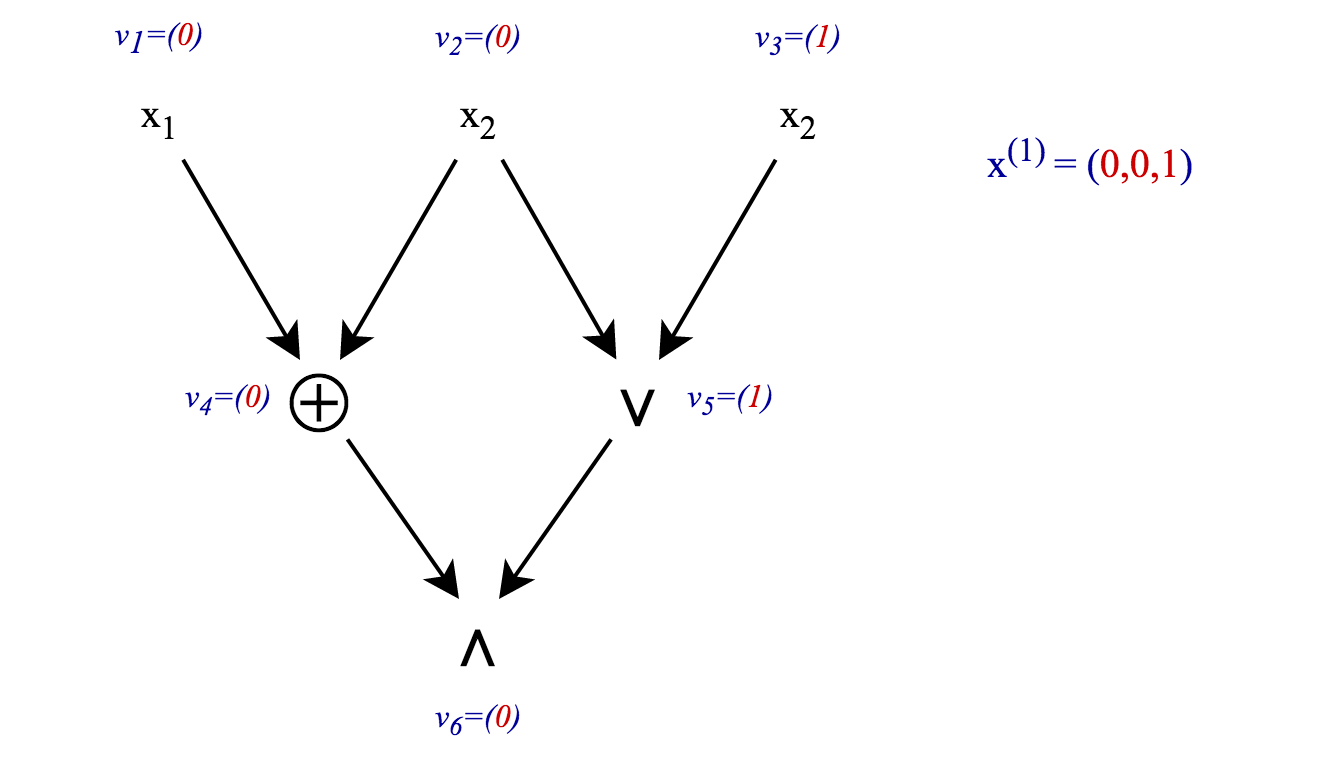

Repeat for another plaintext $x^{(2)} = (0, 1, 0)$, append intermediate values to each node's history.

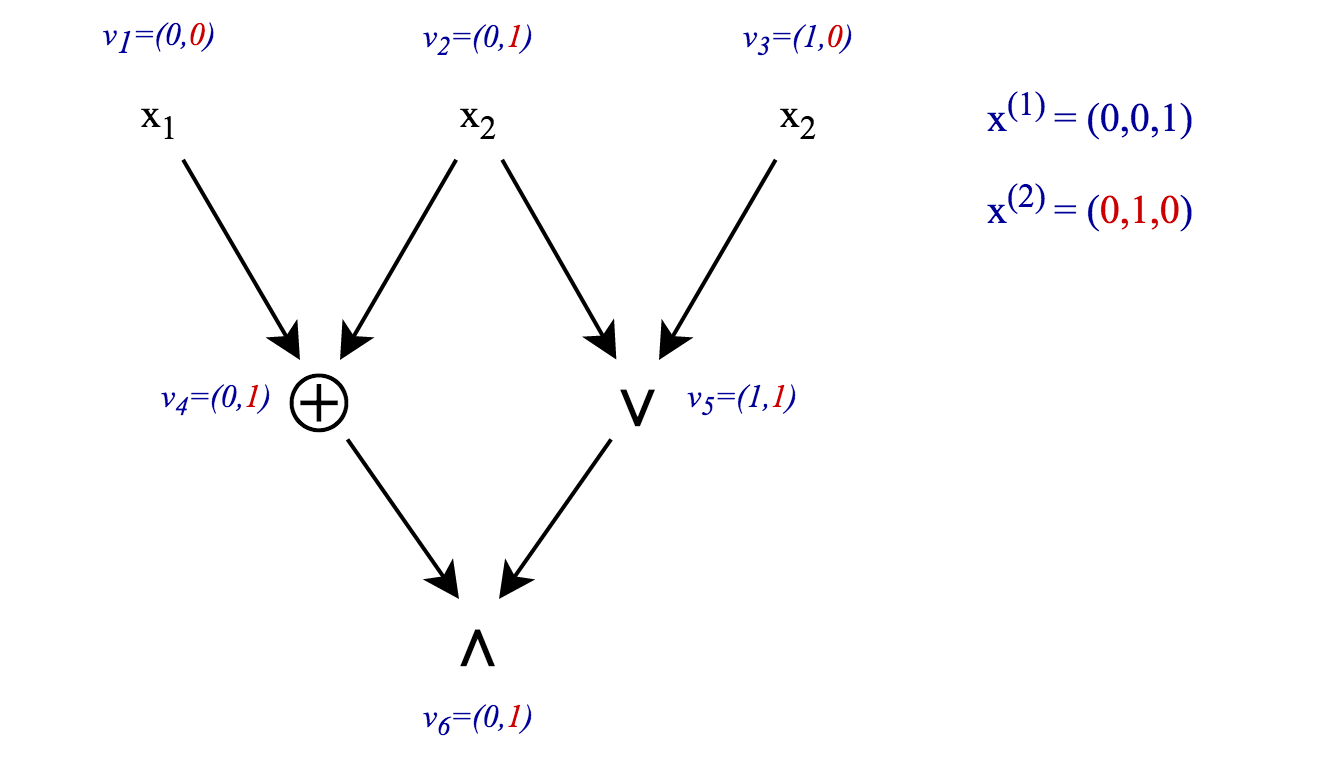

Repeat for another plaintext $x^{(3)} = (1, 1, 1)$.

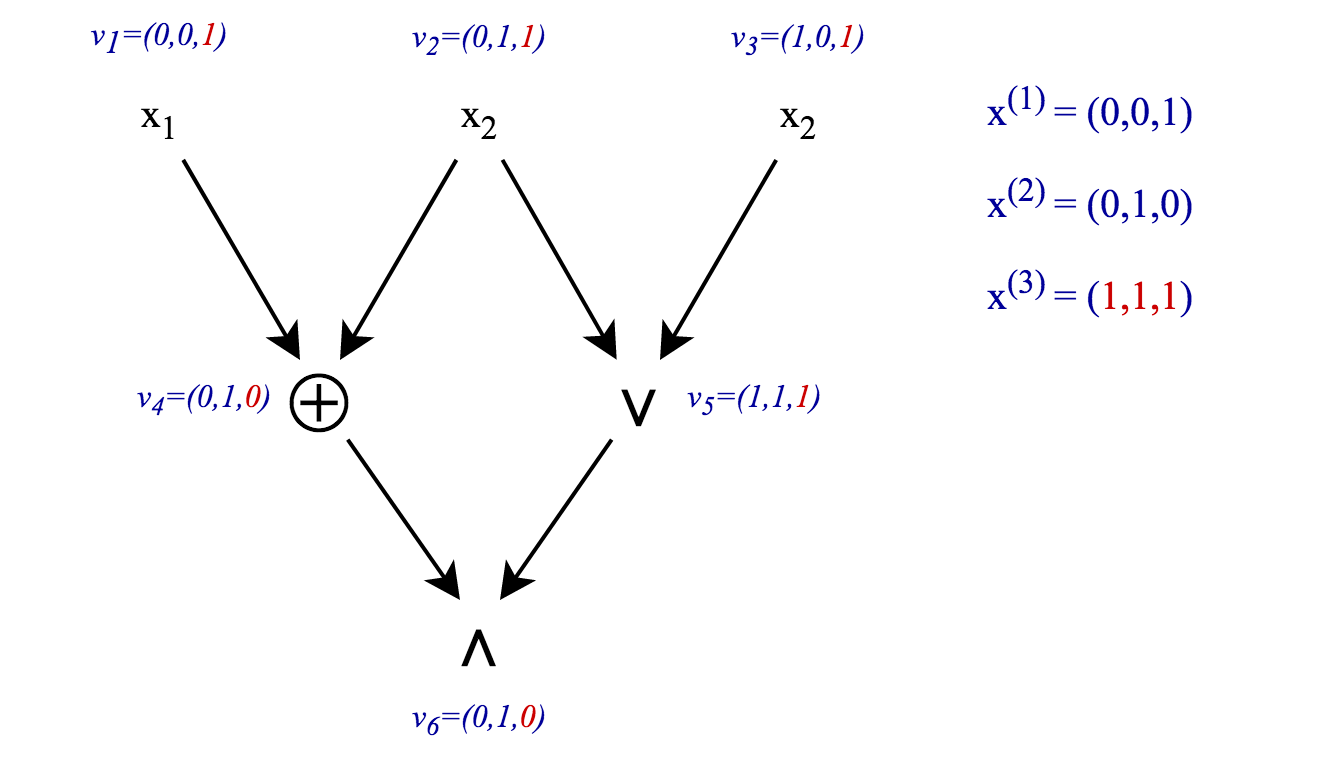

### Setup AES circuit

In [13]:
from binteger import Bin
from circkit.boolean import OptBooleanCircuit as BooleanCircuit
from wbkit.ciphers.aes import BitAES

C = BooleanCircuit(name="AES")

key = b"abcdefghABCDEFGH"
plaintext = b"0123456789abcdef"

pt = C.add_inputs(128)
ct, k10 = BitAES(pt, Bin(key).tuple, rounds=10)
C.add_output(ct)

C.in_place_remove_unused_nodes()
C.print_stats()

ct = C.evaluate(Bin(plaintext).tuple)

AES(OptBooleanCircuit): 
   |   128 inputs,  128 outputs,  31273 nodes
   | XOR:19284 (61.66%), AND:6240 (19.95%), NOT:5621 (17.97%), INPUT:128 (0.41%)


## Record computational traces

Using `circkit` directly:

(useful for small experimetns, too slow/heavy for mass tracing)

In [14]:
C.trace(Bin(plaintext).tuple)

{<OptBooleanCircuit:INPUT[name=x0_0]#0 ()>: 0,
 <OptBooleanCircuit:INPUT[name=x0_1]#1 ()>: 0,
 <OptBooleanCircuit:INPUT[name=x0_2]#2 ()>: 1,
 <OptBooleanCircuit:INPUT[name=x0_3]#3 ()>: 1,
 <OptBooleanCircuit:INPUT[name=x0_4]#4 ()>: 0,
 <OptBooleanCircuit:INPUT[name=x0_5]#5 ()>: 0,
 <OptBooleanCircuit:INPUT[name=x0_6]#6 ()>: 0,
 <OptBooleanCircuit:INPUT[name=x0_7]#7 ()>: 0,
 <OptBooleanCircuit:INPUT[name=x0_8]#8 ()>: 0,
 <OptBooleanCircuit:INPUT[name=x0_9]#9 ()>: 0,
 <OptBooleanCircuit:INPUT[name=x0_10]#10 ()>: 1,
 <OptBooleanCircuit:INPUT[name=x0_11]#11 ()>: 1,
 <OptBooleanCircuit:INPUT[name=x0_12]#12 ()>: 0,
 <OptBooleanCircuit:INPUT[name=x0_13]#13 ()>: 0,
 <OptBooleanCircuit:INPUT[name=x0_14]#14 ()>: 0,
 <OptBooleanCircuit:INPUT[name=x0_15]#15 ()>: 1,
 <OptBooleanCircuit:INPUT[name=x0_16]#16 ()>: 0,
 <OptBooleanCircuit:INPUT[name=x0_17]#17 ()>: 0,
 <OptBooleanCircuit:INPUT[name=x0_18]#18 ()>: 1,
 <OptBooleanCircuit:INPUT[name=x0_19]#19 ()>: 1,
 <OptBooleanCircuit:INPUT[name=x0_20]#20

To do fast recording, we serialize the circuit into an internal binary format, into a file:

In [15]:
from wbkit.serialize import RawSerializer

RawSerializer().serialize_to_file(C, "circuits/aes10_clear.bin")

Now, we can use a fast C-based circuit tracer provided by `wbkit`:

In [1]:
from wbkit.fastcircuit import FastCircuit

plaintext = b"0123456789abcdef"

C = FastCircuit("circuits/aes10_clear.bin")
ciphertext = C.compute_one(plaintext, trace_filename="traces/test")
ciphertext.hex()

'54b03463c5b5a1d45efb4e91637ba51f'

The key feature is bit-sliced **batch** tracing: using 64-bit CPU registers we can trace 64 executions (inputs) of a Boolean circuit at once. This makes massive tracing much faster.

In [2]:
ciphertexts = C.compute_batch([b"my_plaintext_abc", b"anotherPlaintext"] * 4, trace_filename="traces/test2")
ciphertexts

[b'\xa4\x02\xbcLb\x16\xc9\xcf\x07!\xe2+\xd1\xfb\x177',
 b'>\xdbt\xc3\x8b\x93\xf4\xbf\xb2\x1dZ1\xb7S\x04\xc1',
 b'\xa4\x02\xbcLb\x16\xc9\xcf\x07!\xe2+\xd1\xfb\x177',
 b'>\xdbt\xc3\x8b\x93\xf4\xbf\xb2\x1dZ1\xb7S\x04\xc1',
 b'\xa4\x02\xbcLb\x16\xc9\xcf\x07!\xe2+\xd1\xfb\x177',
 b'>\xdbt\xc3\x8b\x93\xf4\xbf\xb2\x1dZ1\xb7S\x04\xc1',
 b'\xa4\x02\xbcLb\x16\xc9\xcf\x07!\xe2+\xd1\xfb\x177',
 b'>\xdbt\xc3\x8b\x93\xf4\xbf\xb2\x1dZ1\xb7S\x04\xc1']

In [3]:
with open("traces/test2", "rb") as f:
    print(f.read(32).hex())

000000000055ff00ff0000550000aa0000aaff00ff00aaff00aa00000000ffaa


# We will prepare